In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


In [8]:
# Loading our specific dataset
df = pd.read_csv('dataset/train_v2_drcat_02-new.csv')

# We only select the text and label columns for our task. In addition, for your knowlege it has 5 different coloumns.
df = df[['text', 'label']]

# shuffling the data for better randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the shape and first few rows of the dataframe
print("Data Shape:", df.shape)
print(df.head())

Data Shape: (44868, 2)
                                                text  label
0  Ummm... hey there!  So, like, I know it's kind...      1
1  Dear Principal,\n\nAs you may know, many stude...      0
2  The cafeteria at our school is an important re...      1
3  Some schools require students to complete summ...      0
4  When considering the advantages and disadvanta...      1


In [9]:
# CONFIGURATION 
VOCAB_SIZE = 20000 # The words are stored based on frequency, we keep the top 20,000 most frequent words
MAX_LENGTH = 300    # Look at the first 300 words of each essay
OOV_TOK = "<OOV>"   # for the words we haven' t seen before

# 1. Setting up Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(df['text'])

# 2. Convert texting to sequences
sequences = tokenizer.texts_to_sequences(df['text'])

# 3. Pad sequences (ensuring all are length 300)
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

# 4. Saving the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved as 'tokenizer.pickle'")

# 5. Splitting the data into Train and Test sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    df['label'].values, 
    test_size=0.2, 
    random_state=42
)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Tokenizer saved as 'tokenizer.pickle'
Training shape: (35894, 300)
Testing shape: (8974, 300)


In [11]:
# Building the model
model = tf.keras.Sequential([
    # Layer 1: Embedding
    # Turning integers into vectors 
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_LENGTH),
    
    # Layer 2: Conv1D
    # Sliding a window over the words to find patterns (like "As an AI language model")
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    
    # Layer 3: Global Max Pooling
    # Grabbing the strongest "signal" found by the convolution
    tf.keras.layers.GlobalMaxPooling1D(),
    
    # Layer 4: Dense (Hidden Layer)
    tf.keras.layers.Dense(24, activation='relu'),
    
    # Layer 5: Dropout (Prevents overfitting)
    tf.keras.layers.Dropout(0.5),
    
    # Layer 6: Output
    # Single neuron. 0 = Human, 1 = AI
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# training the model

early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

# save the version with the lowest val_loss
checkpoint = ModelCheckpoint('best_ai_detector.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    batch_size=8,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/5
4485/4487 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9081 - loss: 0.2002
Epoch 1: val_loss improved from None to 0.02637, saving model to best_ai_detector.keras

Epoch 1: finished saving model to best_ai_detector.keras
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9635 - loss: 0.0985 - val_accuracy: 0.9916 - val_loss: 0.0264
Epoch 2/5
4481/4487 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9937 - loss: 0.0257
Epoch 2: val_loss improved from 0.02637 to 0.02431, saving model to best_ai_detector.keras

Epoch 2: finished saving model to best_ai_detector.keras
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9930 - loss: 0.0279 - val_accuracy: 0.9914 - val_loss: 0.0243
Epoch 3/5
4485/4487 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.0115
Epoch 3: val_loss did not improve from 0.02431
4487/4487 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9959 - loss: 0.0132 - val_accuracy: 0.9930 - val_loss: 0.0279
Epoch 3: early stopping


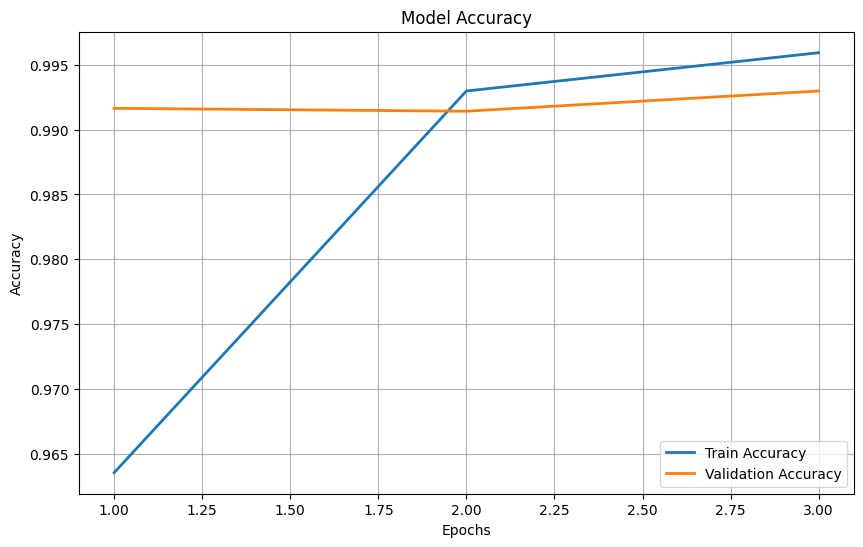

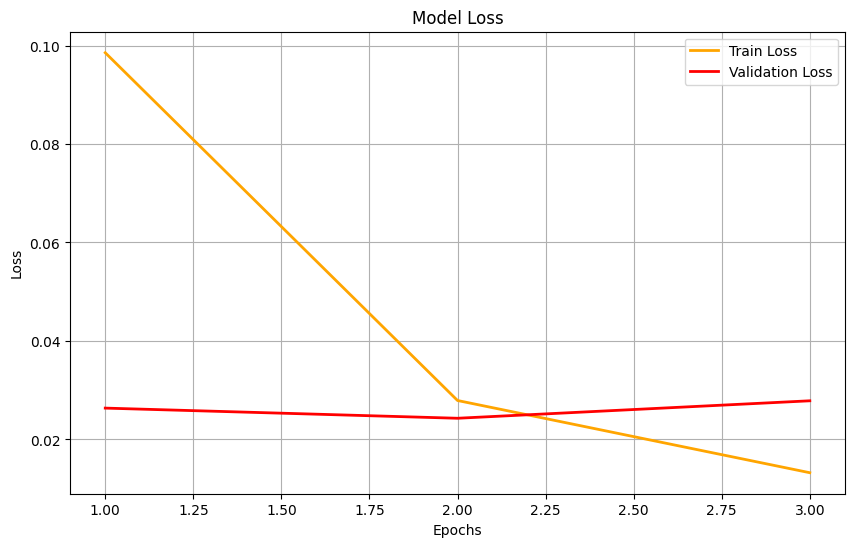

In [13]:
# Visualizing the training results
epochs_range = range(1, len(history.history['accuracy']) + 1)

#  Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#  Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history.history['loss'], label='Train Loss', color='orange', linewidth=2)
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [14]:
# Saving the trained model
# Save in the new Keras format
model.save('ai_detector.keras')
print("Model saved successfully as 'ai_detector.keras'")

Model saved successfully as 'ai_detector.keras'


Reading dataset/evaluation_dataset.jsonl...
Detected JSON Array format. Parsing...
Successfully loaded 34 samples.
Running predictions...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Dataset Evaluation Report:

              precision    recall  f1-score   support

   Human (0)       0.75      0.80      0.77        15
      AI (1)       0.83      0.79      0.81        19

    accuracy                           0.79        34
   macro avg       0.79      0.79      0.79        34
weighted avg       0.80      0.79      0.79        34



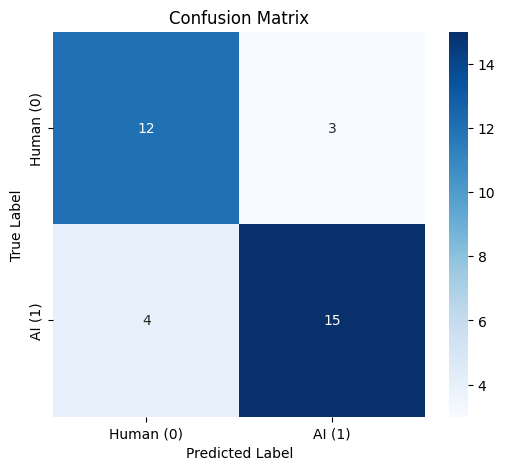

In [15]:
import json
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# configuration along with resources loading
MAX_LENGTH = 300

if 'tokenizer' not in locals():
    print("Tokenizer not found in memory. Loading from 'tokenizer.pickle'...")
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

if 'model' not in locals():
    print("Model not found in memory. Loading from 'best_ai_detector.keras'...")
    model = load_model('best_ai_detector.keras')

# loading and parsing the JSONL evaluation dataset
jsonl_path = "dataset/evaluation_dataset.jsonl"
texts = []
labels = []

print(f"Reading {jsonl_path}...")
with open(jsonl_path, "r", encoding="utf-8") as f:
    raw_content = f.read()
fixed_content = re.sub(r',\s*([\]}])', r'\1', raw_content)

try:
    # Try parsing the whole file as a JSON Array (List of objects)
    if fixed_content.strip().startswith('['):
        print("Detected JSON Array format. Parsing...")
        data = json.loads(fixed_content)
        for row in data:
            texts.append(row["text"])
            labels.append(row["label"])
            
    else:
        # Fallback: Treat as Line-delimited JSON
        print("Detected JSON Lines format. Parsing line by line...")
        for line in fixed_content.splitlines():
            if not line.strip(): continue
            row = json.loads(line)
            texts.append(row["text"])
            labels.append(row["label"])

except json.JSONDecodeError as e:
    print(f"❌ JSON Error: {e}")

# checking and predecting 
if len(texts) == 0:
    print("ERROR: No valid data found!")
else:
    print(f"Successfully loaded {len(texts)} samples.")
    labels = np.array(labels)

    # Preprocessing the data
    seqs = tokenizer.texts_to_sequences(texts)
    X_eval_padded = pad_sequences(seqs, maxlen=MAX_LENGTH, padding="post", truncating="post")

    # Predicting on the json evaluation dataset
    print("Running predictions...")
    eval_probs = model.predict(X_eval_padded).flatten()
    eval_preds = (eval_probs >= 0.5).astype(int)
    print("\nDataset Evaluation Report:\n")
    print(classification_report(labels, eval_preds, target_names=["Human (0)", "AI (1)"]))

    # Confusion Matrix creation
    cm_eval = confusion_matrix(labels, eval_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_eval, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Human (0)", "AI (1)"],
                yticklabels=["Human (0)", "AI (1)"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [16]:
# Testing the model performance 
def predict_text(text):
    # 1. Tokenize and Pad the new text
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
    
    # 2. Predict
    prediction = model.predict(padded)
    score = prediction[0][0]
    
    # 3. Output
    print(f"Text: '{text[:50]}...'")
    print(f"AI Score: {score:.4f}")
    if score > 0.5:
        print(">> VERDICT: AI GENERATED 🤖")
    else:
        print(">> VERDICT: HUMAN WRITTEN 🧑‍🎓")
    print("-" * 30)

# Try some examples
predict_text("If I looked through my sock drawer, I am sure that I would find many more stories, many more places. I know, for instance, that there are some mottled gray wools with holes that could reminisce about cold-weather camping trips with Boy Scout Troop 10. They might also tell of the times they served to replace the ripped cloth boots from my roller blades. Perhaps, though, they would just complain about being neglected of late, in favor of the two newer pairs of softer, less itchy wool-blends; the ones that talk of churches, and also speak of sandals. Or maybe they would fault the black, thick dress wools with the elastic all stretched out (they have tales to tell about frigid marching band shows with the cuffs of the flannel pants I wore under my uniform tucked in so they wouldn’t show) for being part of what has kept me from camping and skating for the last four years.")
predict_text("Social media can be fun, but it also gets stressful fast. You can scroll for five minutes and suddenly it turns into an hour without you realizing it. Sometimes it makes you compare your life to other people’s, even though you know it’s not completely real. I think it’s good for staying connected, but it can mess with your mood. Taking breaks from it actually helps more than people admit.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Text: 'If I looked through my sock drawer, I am sure that...'
AI Score: 0.0000
>> VERDICT: HUMAN WRITTEN 🧑‍🎓
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Text: 'Social media can be fun, but it also gets stressfu...'
AI Score: 1.0000
>> VERDICT: AI GENERATED 🤖
------------------------------
